# Analysing and Estimate of Wind Shear Through Machine Learning #


# INTRODUCTION



GE Wind team has come up with the new idea to use load sensor data to estimate wind shear. As Analytics engineer our task is to analyse the feasibility of this new idea and make a recommendation as to whether GE Wind should launch an NPI program to offer a “Virtual Wind Shear Sensor” using the data collected from the load sensors on its next generation of Wind Turbines.As of today, wind shear is not considered in optimizing wind turbine power.To obtain wind shear, 5 wind speed (lidar) sensors installed at different altitudes on a costly met mast.

Project Deliverables
Part A: Develop an algorithm to classify wind speed profile:
Our first task is to develop and evaluate a classifier to see how well a speed profile can be determined from the load sensor data.

Part B: Estimation of  α from load sensor data:
Create a predictive model for α from the load sensor data and determine how well it estimates the actual α

Part C: Estimation of Shear when speed profile does not follow a power law
For speed profiles labeled as 1, 2, and 3, how might you create a model to estimate these profiles?

In [54]:
# Importing the libraries
import numpy as np
import pandas as pd
from scipy import interp
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import math
import datetime
import matplotlib.dates as mdates
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib


# The Data Set

- The data set is available in .csv format and has 8046 rows and 21 columns. The information presented in this dataset is quite comprehensive,this included 12 days from 17th June'15 to 28th June'15, captured in every 2 minutes timeframe from one wind turbine sensors installed at different altitudes of 38m, 58m, 78.7m, 103m, and 122m on a costly met mast.The load sensor data of nodding, pitching, yawing, and other loading parameters was taken from the load sensors installed in the hub at the altitude of 78.7m 
- The data set does not have any missing values.
- One column was added 'alpha' in the dataset which is the wind shear to be predicted using the Load sensor data.
- One more column was added in dataset "Date" to do the analysis date wise. 
- The load sensor data (14 variables)(X) are used to classify the wind speed profiles (Y).
- The load sensor data (14 variables)(X) are used to create the predictive model for alpha 

In [55]:
# Importing the dataset
dataset = pd.read_csv('C:\\Users\\105051884\\Desktop\\my folder\\My Projects\WindFarm.csv')

In [56]:
dataset.head()

,datetime,m38,m58,m78,m103,m122,RPM_0P,nodd_0P,nodd_3C,nodd_3S,...,pitch_q_0P,pitch_d_3C,pitch_d_3S,yaw_0P,yaw_3C,yaw_3S,P_el,V_estim,pitch_col_0P,ShearTypeClass
0,6/17/2015 10:30,4.4717,4.6109,4.8745,5.0853,5.4753,8.1277,-86.9110,78.830,-33.6540,...,-0.000327,-0.000294,-0.000010,-27.937,30.3730,-19.6560,176.25,4.6767,0.20502,0
1,6/17/2015 10:32,4.4569,4.6785,4.6491,5.0090,5.3769,8.0066,-64.3130,64.517,-4.8061,...,-0.000480,-0.000023,0.000058,35.079,84.5340,47.6850,137.67,4.3312,0.30504,0
2,6/17/2015 10:34,4.5101,4.8701,4.7262,5.0403,5.2448,8.0077,-33.8290,63.639,14.0920,...,-0.000342,-0.000037,0.000015,43.103,55.0680,22.4870,156.08,4.4070,0.32552,0
3,6/17/2015 10:36,4.4407,4.6644,4.8234,5.0289,5.0884,8.0051,8.6289,52.397,32.0280,...,-0.000502,-0.000164,-0.000359,11.489,4.9774,-14.6380,139.10,4.3555,0.25064,0
4,6/17/2015 10:38,4.1184,4.2720,4.3862,4.7237,4.9073,8.0064,73.7360,26.205,29.2370,...,-0.000666,-0.000031,-0.000418,67.425,-4.0671,-6.4312,127.65,4.2269,0.25935,0


In [57]:
# Calculating alpha for the actual dataset
mdiv = dataset.m38/dataset.m78
logmdiv = np.log(mdiv)
lognum = np.log(38/78.7)
alpha = logmdiv/lognum

In [58]:
# Converting alpha to dataframe
alpha = pd.DataFrame(alpha)

In [59]:
# Adding alpha to the dataset
dataset['alpha'] = alpha

In [60]:
dataset['Date'] = pd.to_datetime(dataset['datetime']).dt.date


In [61]:
dataset.head()

,datetime,m38,m58,m78,m103,m122,RPM_0P,nodd_0P,nodd_3C,nodd_3S,...,pitch_d_3S,yaw_0P,yaw_3C,yaw_3S,P_el,V_estim,pitch_col_0P,ShearTypeClass,alpha,Date
0,6/17/2015 10:30,4.4717,4.6109,4.8745,5.0853,5.4753,8.1277,-86.9110,78.830,-33.6540,...,-0.000010,-27.937,30.3730,-19.6560,176.25,4.6767,0.20502,0,0.118464,2015-06-17
1,6/17/2015 10:32,4.4569,4.6785,4.6491,5.0090,5.3769,8.0066,-64.3130,64.517,-4.8061,...,0.000058,35.079,84.5340,47.6850,137.67,4.3312,0.30504,0,0.057990,2015-06-17
2,6/17/2015 10:34,4.5101,4.8701,4.7262,5.0403,5.2448,8.0077,-33.8290,63.639,14.0920,...,0.000015,43.103,55.0680,22.4870,156.08,4.4070,0.32552,0,0.064284,2015-06-17
3,6/17/2015 10:36,4.4407,4.6644,4.8234,5.0289,5.0884,8.0051,8.6289,52.397,32.0280,...,-0.000359,11.489,4.9774,-14.6380,139.10,4.3555,0.25064,0,0.113545,2015-06-17
4,6/17/2015 10:38,4.1184,4.2720,4.3862,4.7237,4.9073,8.0064,73.7360,26.205,29.2370,...,-0.000418,67.425,-4.0671,-6.4312,127.65,4.2269,0.25935,0,0.086530,2015-06-17


In [12]:
test_dataset = dataset[1:]

In [17]:
test_dataset_grouped = test_dataset.groupby('Date').mean().reset_index()

In [19]:
test_dataset_grouped

,Date,m38,m58,m78,m103,m122,RPM_0P,nodd_0P,nodd_3C,nodd_3S,...,pitch_d_3C,pitch_d_3S,yaw_0P,yaw_3C,yaw_3S,P_el,V_estim,pitch_col_0P,ShearTypeClass,alpha
0,2015-06-17,8.212077,9.557729,10.711877,11.904806,12.754317,13.776247,-654.383670,31.510785,70.917697,...,-0.092506,-0.006530,16.356977,36.087005,-33.444243,1919.740501,10.393959,3.533420,0.037037,0.366239
1,2015-06-18,7.111681,8.132764,8.942074,9.770736,10.125901,12.826879,-511.992461,30.804718,80.654467,...,-0.074808,0.007671,50.809062,39.324126,-38.494663,1359.002339,8.751884,1.780874,0.066667,0.312951
2,2015-06-19,7.061544,8.462851,9.690456,10.979459,11.749996,13.666774,-762.481219,37.313493,121.533731,...,-0.102057,0.003858,70.142473,70.252596,-39.461779,1663.527153,9.485891,1.863918,0.048611,0.467055
3,2015-06-20,8.854572,9.696874,10.410222,11.101440,11.611120,13.643082,-507.053894,13.779056,61.319045,...,-0.066946,-0.004262,45.771547,29.736710,-24.363493,1729.088988,10.163555,3.483473,0.063889,0.213745
4,2015-06-21,7.891549,8.889158,9.668034,10.464525,11.008175,13.418066,-549.444133,28.489896,77.038442,...,-0.042414,0.002091,71.602815,43.147050,-39.489131,1534.638678,9.437868,2.463514,0.094444,0.280391
5,2015-06-22,6.664227,7.591121,8.430046,9.358994,10.086181,12.965341,-673.207607,27.564529,63.646246,...,-0.018435,0.002872,63.055644,35.040109,-34.389007,1204.669111,8.305077,0.853553,0.118056,0.348105
6,2015-06-23,7.702512,8.800579,9.581230,10.446191,10.985016,13.595199,-547.627690,10.701878,46.782257,...,-0.061535,-0.003745,59.022501,12.867542,-30.874500,1575.617264,9.403527,2.079106,0.054167,0.300173
7,2015-06-24,10.074301,11.054634,11.788943,12.493395,12.955148,14.138097,-646.672227,13.301356,67.013279,...,-0.086055,-0.006642,35.707602,24.498219,-28.262756,2063.803556,11.448302,5.311953,0.075000,0.229963
8,2015-06-25,8.687535,9.803253,10.667988,11.529668,12.038065,13.864995,-629.699411,22.204164,86.700354,...,-0.085337,-0.010125,42.923661,43.410324,-31.058547,1810.522653,10.395222,3.561699,0.077778,0.284096
9,2015-06-26,6.007455,7.602133,8.845478,9.737833,10.185601,12.723637,-645.486757,155.129237,164.137420,...,-0.110274,0.007656,75.359333,133.975381,-87.718255,1272.879324,8.498929,1.404371,0.916667,0.583317


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8046 entries, 0 to 8045
Data columns (total 23 columns):
datetime          8046 non-null object
m38               8046 non-null float64
m58               8046 non-null float64
m78               8046 non-null float64
m103              8046 non-null float64
m122              8046 non-null float64
RPM_0P            8046 non-null float64
nodd_0P           8046 non-null float64
nodd_3C           8046 non-null float64
nodd_3S           8046 non-null float64
pitch_d_0P        8046 non-null float64
pitch_q_0P        8046 non-null float64
pitch_d_3C        8046 non-null float64
pitch_d_3S        8046 non-null float64
yaw_0P            8046 non-null float64
yaw_3C            8046 non-null float64
yaw_3S            8046 non-null float64
P_el              8046 non-null float64
V_estim           8046 non-null float64
pitch_col_0P      8046 non-null float64
ShearTypeClass    8046 non-null int64
alpha             8046 non-null float64
Date            

In [22]:
dataset.isnull().any()
# No Null column in the dataset

datetime          False
m38               False
m58               False
m78               False
m103              False
m122              False
RPM_0P            False
nodd_0P           False
nodd_3C           False
nodd_3S           False
pitch_d_0P        False
pitch_q_0P        False
pitch_d_3C        False
pitch_d_3S        False
yaw_0P            False
yaw_3C            False
yaw_3S            False
P_el              False
V_estim           False
pitch_col_0P      False
ShearTypeClass    False
alpha             False
Date              False
dtype: bool

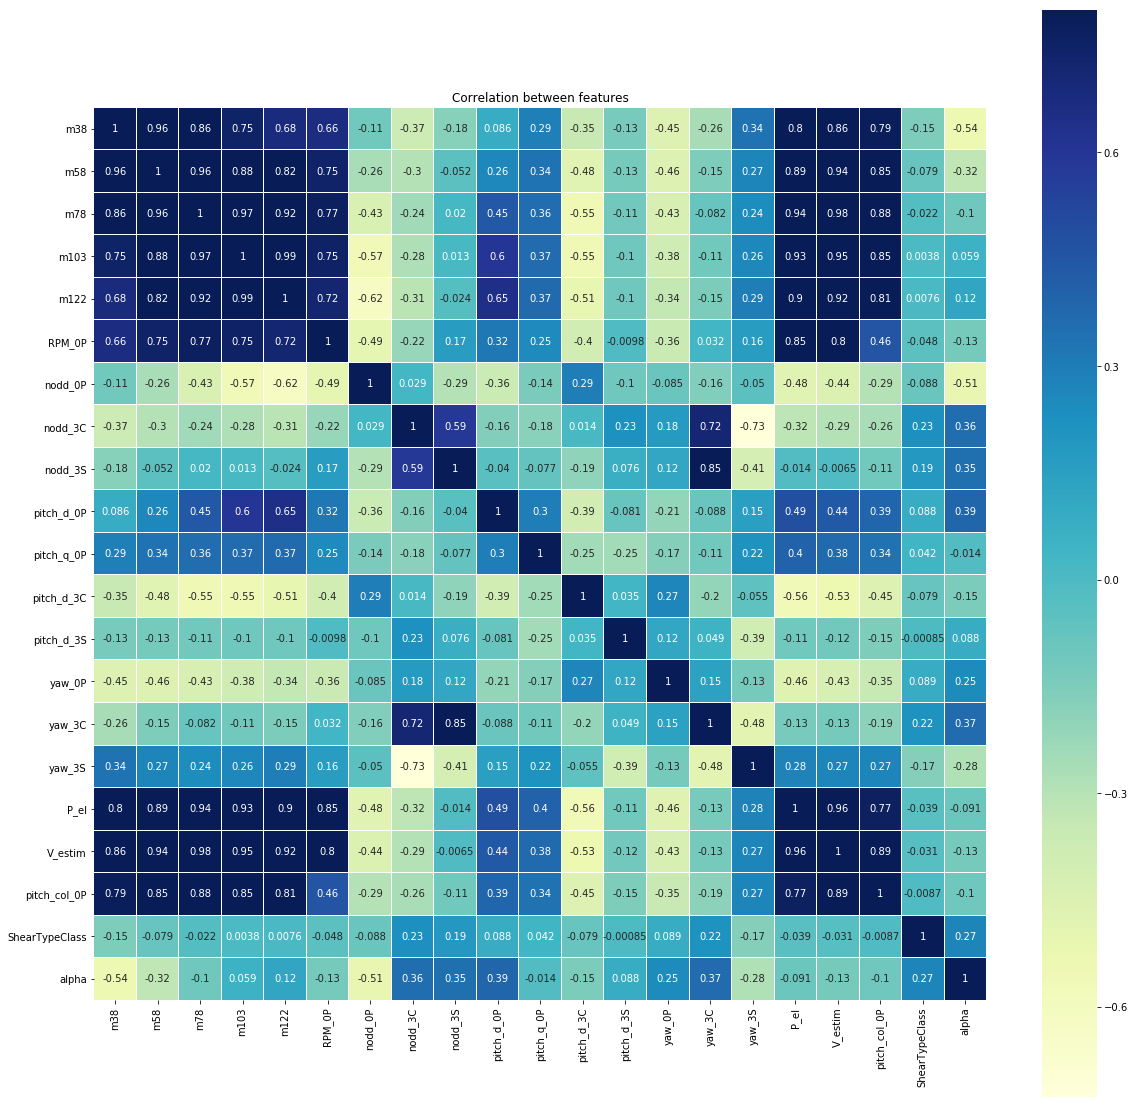

In [23]:
corr = dataset.corr()
plt.figure(figsize=(20,20))

sns.heatmap(corr, vmax=0.8, linewidths=0.01, square=True, annot=True, cmap='YlGnBu', linecolor='white')
plt.title('Correlation between features');

In [24]:
# correlation of features with target variable
dataset.corr()['ShearTypeClass']

m38              -0.153718
m58              -0.078944
m78              -0.021729
m103              0.003778
m122              0.007586
RPM_0P           -0.048312
nodd_0P          -0.087513
nodd_3C           0.229597
nodd_3S           0.188551
pitch_d_0P        0.087678
pitch_q_0P        0.042116
pitch_d_3C       -0.078834
pitch_d_3S       -0.000853
yaw_0P            0.088732
yaw_3C            0.216812
yaw_3S           -0.170109
P_el             -0.039111
V_estim          -0.031206
pitch_col_0P     -0.008750
ShearTypeClass    1.000000
alpha             0.269770
Name: ShearTypeClass, dtype: float64

#### Wind Shear Type Class is having positive correlation with Nodding_3C , Yawing_3C and strong negative coorelation with Yawing_3S and Wind speed at 38 mts

In [25]:
dataset.corr()['alpha']

m38              -0.541118
m58              -0.322727
m78              -0.103071
m103              0.059270
m122              0.120830
RPM_0P           -0.128139
nodd_0P          -0.506802
nodd_3C           0.355301
nodd_3S           0.348063
pitch_d_0P        0.391893
pitch_q_0P       -0.014089
pitch_d_3C       -0.145948
pitch_d_3S        0.088389
yaw_0P            0.248708
yaw_3C            0.367850
yaw_3S           -0.283705
P_el             -0.090891
V_estim          -0.129956
pitch_col_0P     -0.102807
ShearTypeClass    0.269770
alpha             1.000000
Name: alpha, dtype: float64

#### Wind Shear alpha is having positive correlation with Pitching D component (pitch_d_0P) , Yawing_3C , Nodding_3C and Nodding_3S

In [ ]:
mat

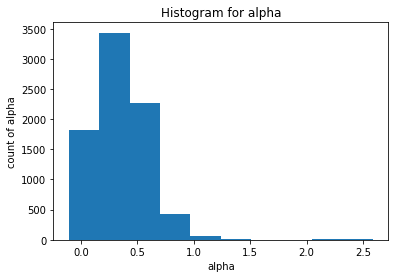

In [26]:
hist = (plt.hist(data= dataset, x ='alpha', bins= 10, stacked=False),\
        plt.title('Histogram for alpha'),\
        plt.xlabel('alpha'),\
        plt.ylabel('count of alpha'))

#### The highest number of alpha count is in between 0.1 to 0.4 which is around 3400

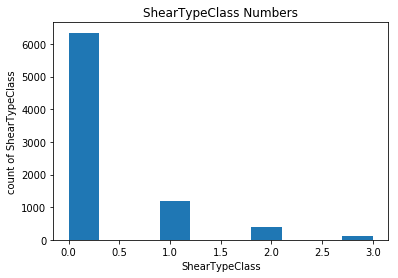

In [27]:
hist = (plt.hist(data= dataset, x ='ShearTypeClass', bins= 10, stacked=False),\
        plt.title('ShearTypeClass Numbers'),\
        plt.xlabel('ShearTypeClass'),\
        plt.ylabel('count of ShearTypeClass'))

#### Around 80% of the "Shear Type class" is "Power Law"

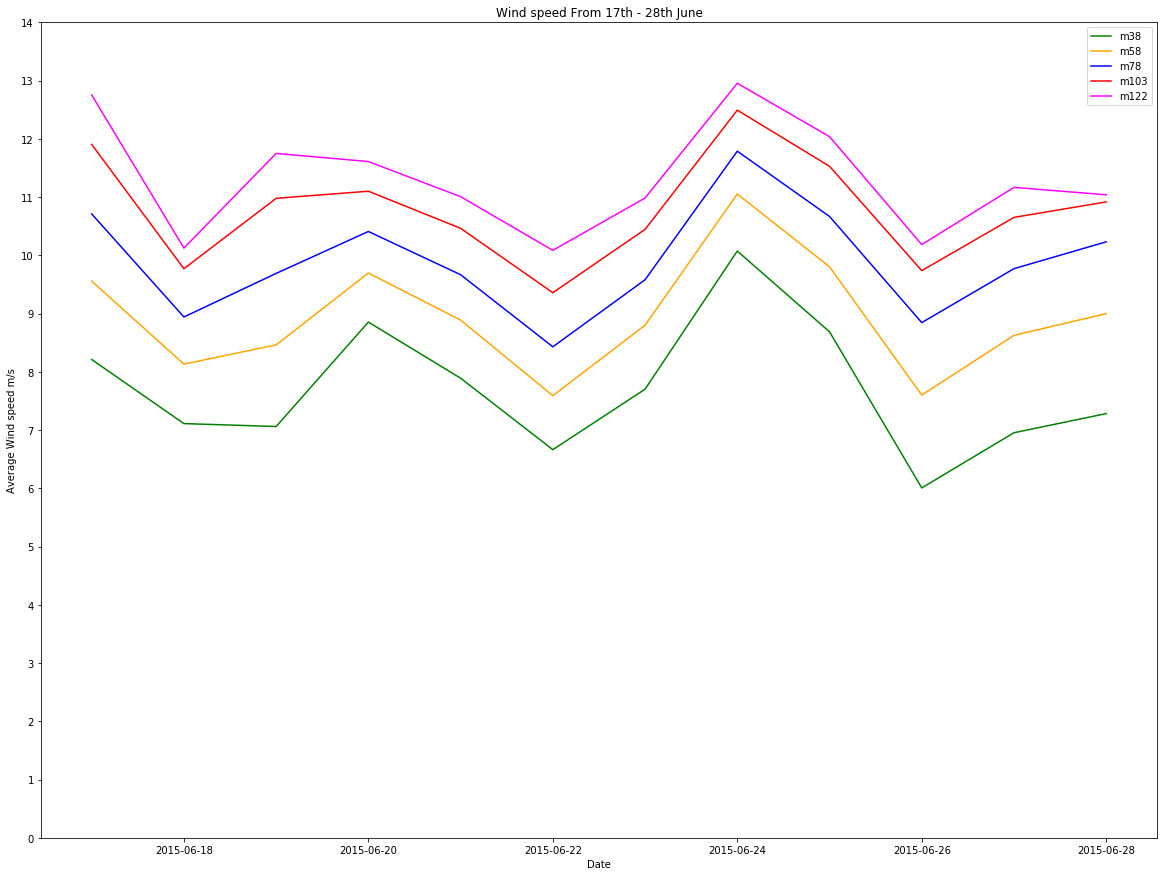

In [45]:
# WIND SPEED AT DIFFERENT HEIGHTS ON 17TH JUNE 2015
plt.figure(figsize=(20,15))
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.m38, color='g')
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.m58, color='orange')
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.m78, color='blue')
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.m103, color='red')
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.m122, color='magenta')
plt.xlabel('Date')
plt.yticks(np.arange(0,15,1))
plt.ylabel('Average Wind speed m/s')
plt.title('Wind speed From 17th - 28th June')
plt.legend()
plt.show()

#### Average Wind Speed is Highest on 24th June'15 and Lowest on 26th June'15

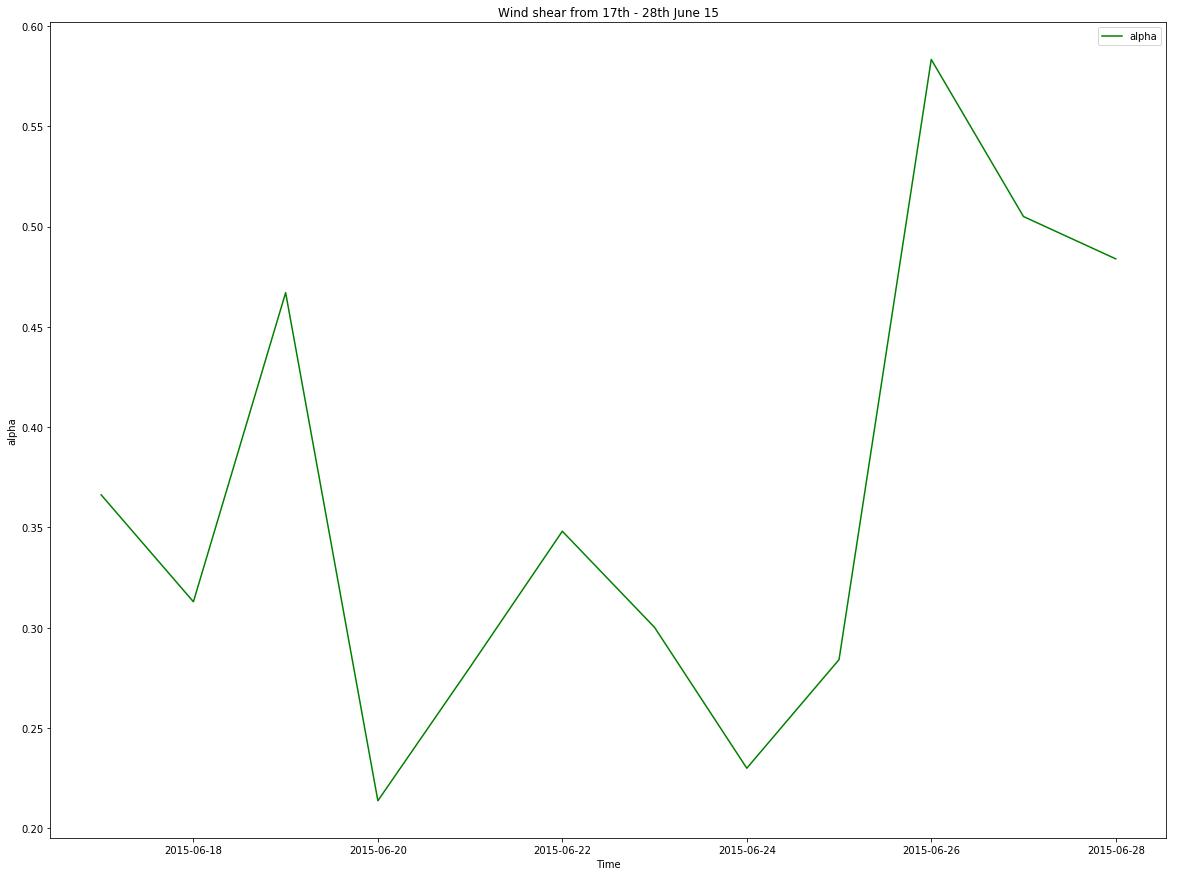

In [48]:
plt.figure(figsize=(20,15))
plt.plot(test_dataset_grouped.Date, test_dataset_grouped.alpha, color='g')
plt.xlabel('Time')
plt.ylabel('alpha')
plt.title('Wind shear from 17th - 28th June 15')
plt.legend()
plt.show()

#### Wind Shear (alpha) is highest on 26th June'15 but seen lowest on 20th and 24th June'15

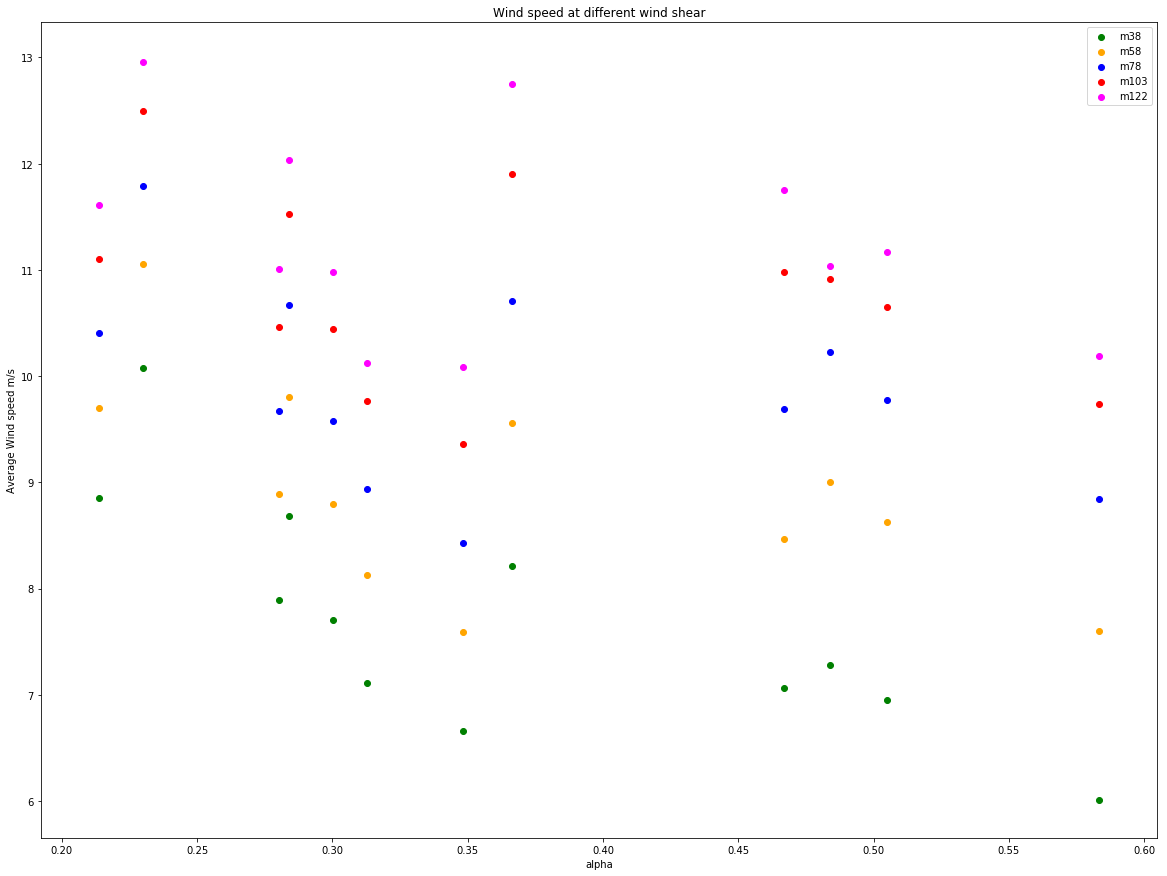

In [47]:
# AVERAGE WIND SPEED AT DIFFERENT HEIGHTS AT DIFFERENT WIND SHEAR(ALPHA)
plt.figure(figsize=(20,15))
plt.scatter(test_dataset_grouped.alpha,test_dataset_grouped.m38, color='g')
plt.scatter(test_dataset_grouped.alpha,test_dataset_grouped.m58, color='orange')
plt.scatter(test_dataset_grouped.alpha,test_dataset_grouped.m78, color='blue')
plt.scatter(test_dataset_grouped.alpha,test_dataset_grouped.m103, color='red')
plt.scatter(test_dataset_grouped.alpha,test_dataset_grouped.m122, color='magenta')
plt.xlabel('alpha')
plt.ylabel('Average Wind speed m/s')
plt.title('Wind speed at different wind shear')
plt.legend()
plt.show()

#### Analysis of Relationship between alpha and Wind Speed:

##- At higher Wind speeds, the values of alpha is observed at lowest points e.g - in between alpha (0.22 -0.23) the wind speed is observed above > 10 m/s at different heights
##- In the above charts " Wind speed From 17th - 28th June" and "Wind shear from 17th - 28th June 15" it is clearly seen that on 24th June'15 when the wind speed is at the highest , the alpha is at the lowest point.



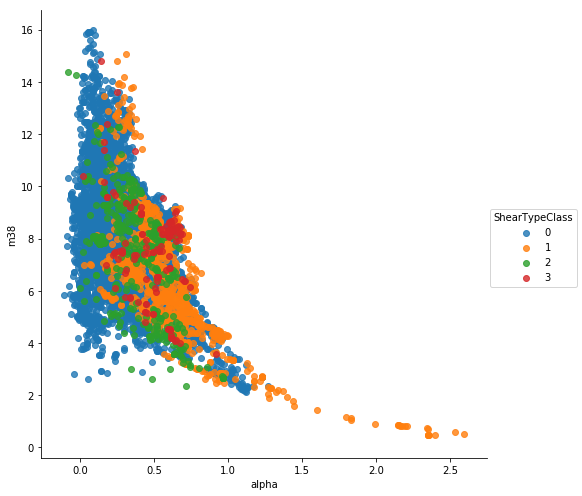

In [22]:
vis2 = sns.lmplot(data=dataset, x='alpha', y= 'm38',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

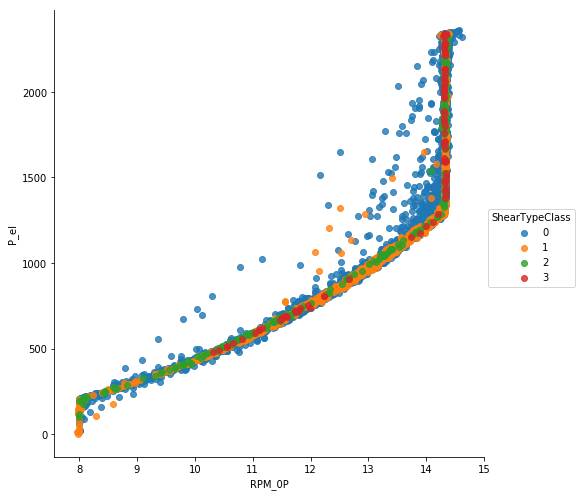

In [43]:
vis5 = sns.lmplot(data=dataset, x='RPM_0P', y= 'P_el',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

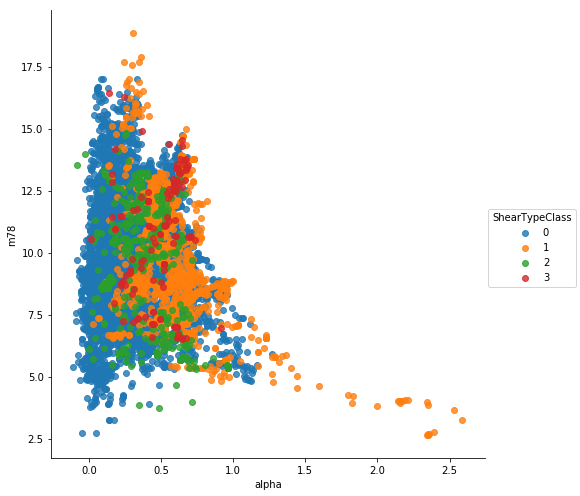

In [23]:
vis3 = sns.lmplot(data=dataset, x='alpha', y= 'm78',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

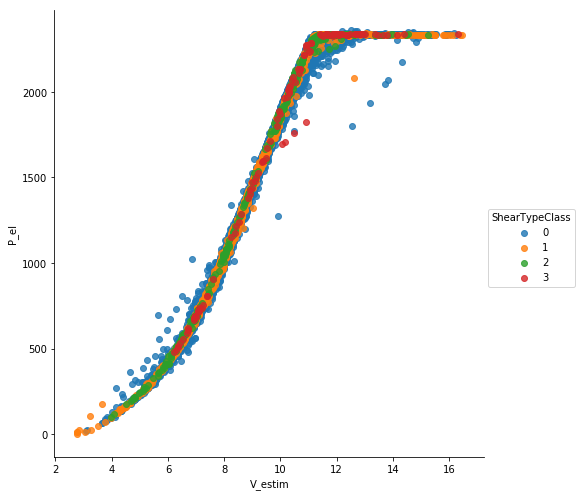

In [53]:
vis4 = sns.lmplot(data=dataset, x='V_estim', y= 'P_el',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)


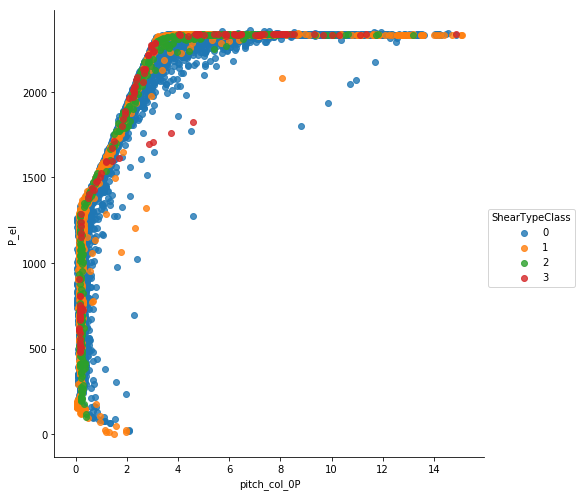

In [26]:
vis6 = sns.lmplot(data=dataset, x='pitch_col_0P', y= 'P_el',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

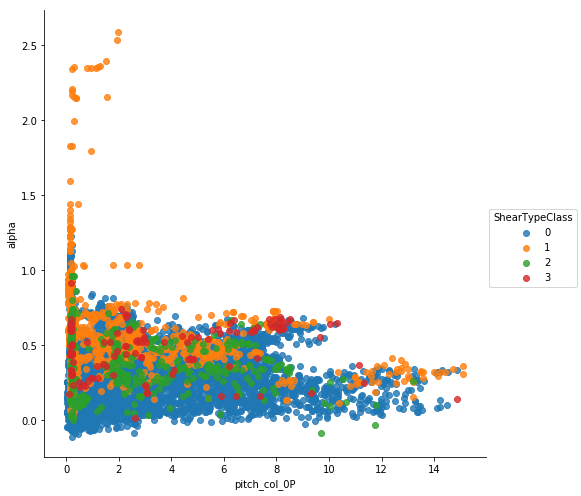

In [27]:
vis6 = sns.lmplot(data=dataset, x='pitch_col_0P', y= 'alpha',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

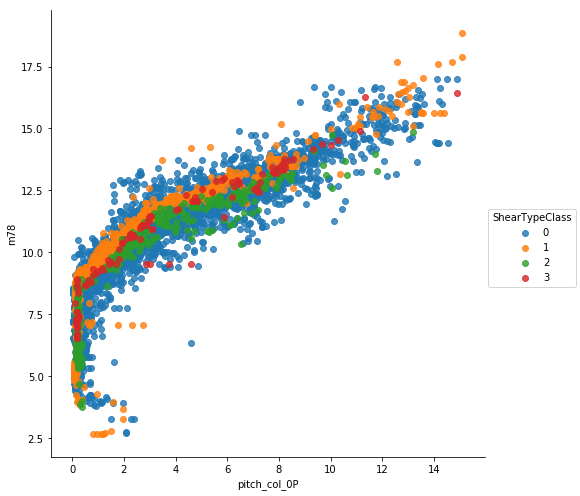

In [28]:
vis7 = sns.lmplot(data=dataset, x='pitch_col_0P', y= 'm78',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

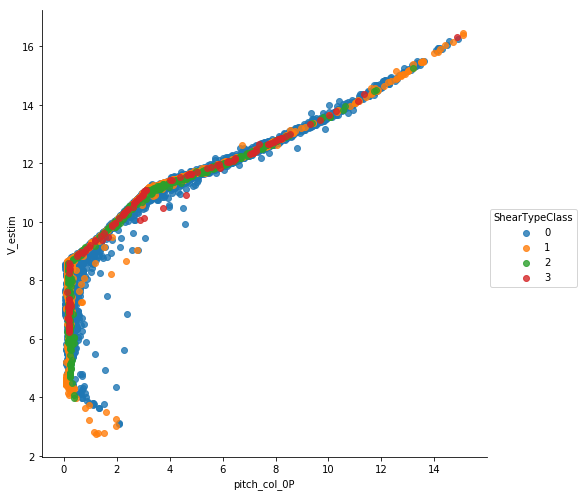

In [29]:
vis8 = sns.lmplot(data=dataset, x='pitch_col_0P', y= 'V_estim',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

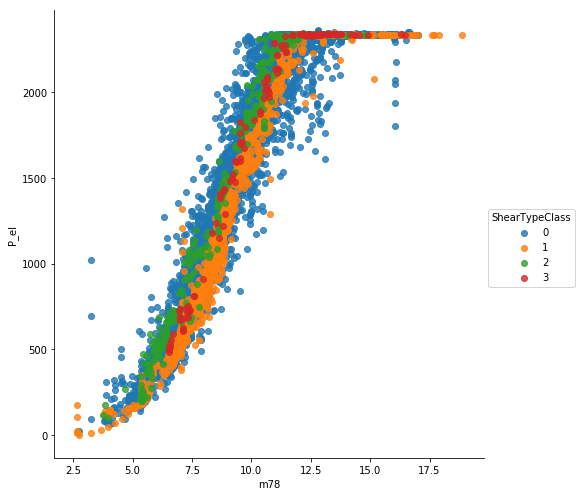

In [30]:
vis6 = sns.lmplot(data=dataset, x='m78', y= 'P_el',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

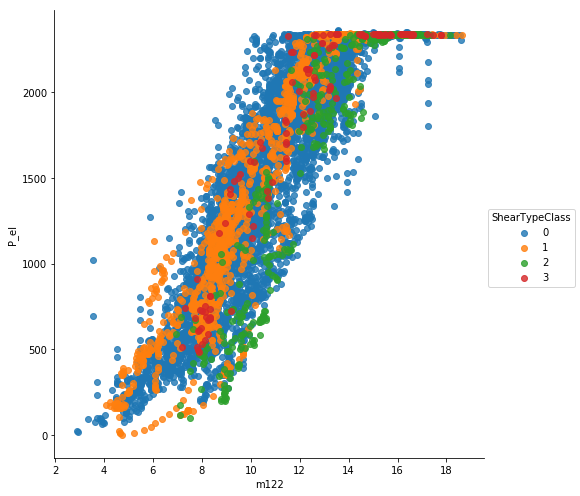

In [31]:
vis6 = sns.lmplot(data=dataset, x='m122', y= 'P_el',\
                   fit_reg=False, hue='ShearTypeClass',\
                   size=7, aspect=1)

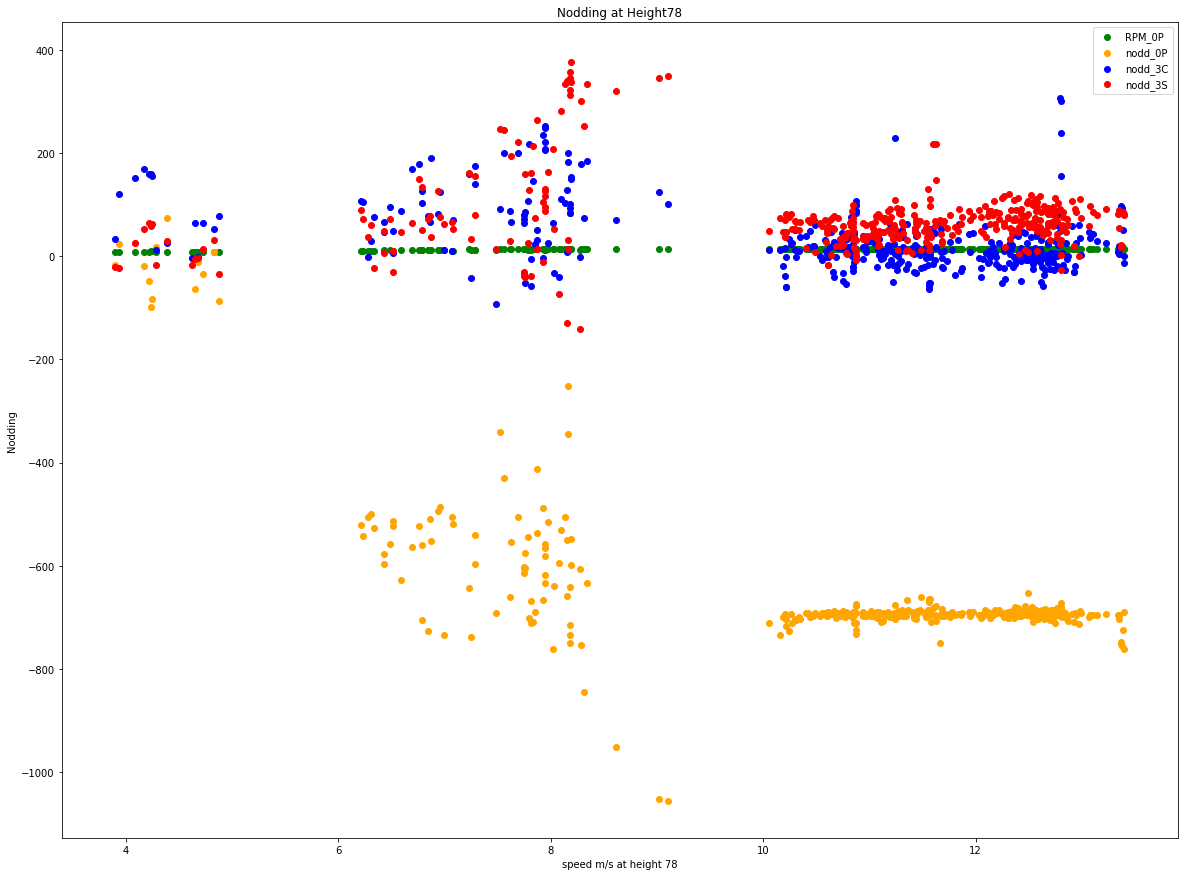

In [32]:
# At height 78 nodding, pitching, yawing, and other loading parameters on 17TH JUNE 2015
plt.figure(figsize=(20,15))
plt.scatter(dataset.m78[0:407], dataset.RPM_0P[0:407], color='g')
plt.scatter(dataset.m78[0:407], dataset.nodd_0P[0:407], color='orange')
plt.scatter(dataset.m78[0:407], dataset.nodd_3C[0:407], color='blue')
plt.scatter(dataset.m78[0:407], dataset.nodd_3S[0:407], color='red')
plt.xlabel('speed m/s at height 78')
plt.ylabel('Nodding')
plt.title('Nodding at Height78')
plt.legend()
plt.show()

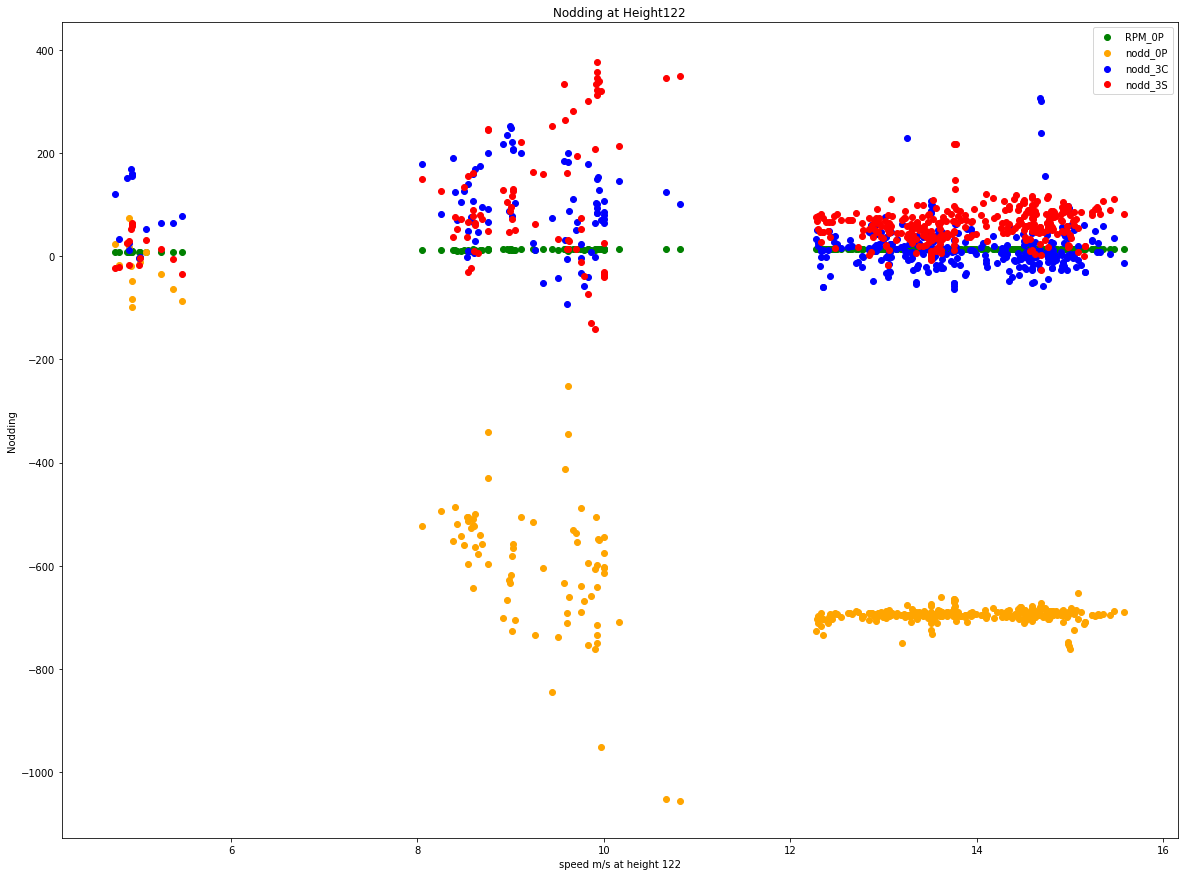

In [33]:
# At height 122 nodding, pitching, yawing, and other loading parameters on 17TH JUNE 2015
plt.figure(figsize=(20,15))
plt.scatter(dataset.m122[0:407], dataset.RPM_0P[0:407], color='g')
plt.scatter(dataset.m122[0:407], dataset.nodd_0P[0:407], color='orange')
plt.scatter(dataset.m122[0:407], dataset.nodd_3C[0:407], color='blue')
plt.scatter(dataset.m122[0:407], dataset.nodd_3S[0:407], color='red')
plt.xlabel('speed m/s at height 122')
plt.ylabel('Nodding')
plt.title('Nodding at Height122')
plt.legend()
plt.show()

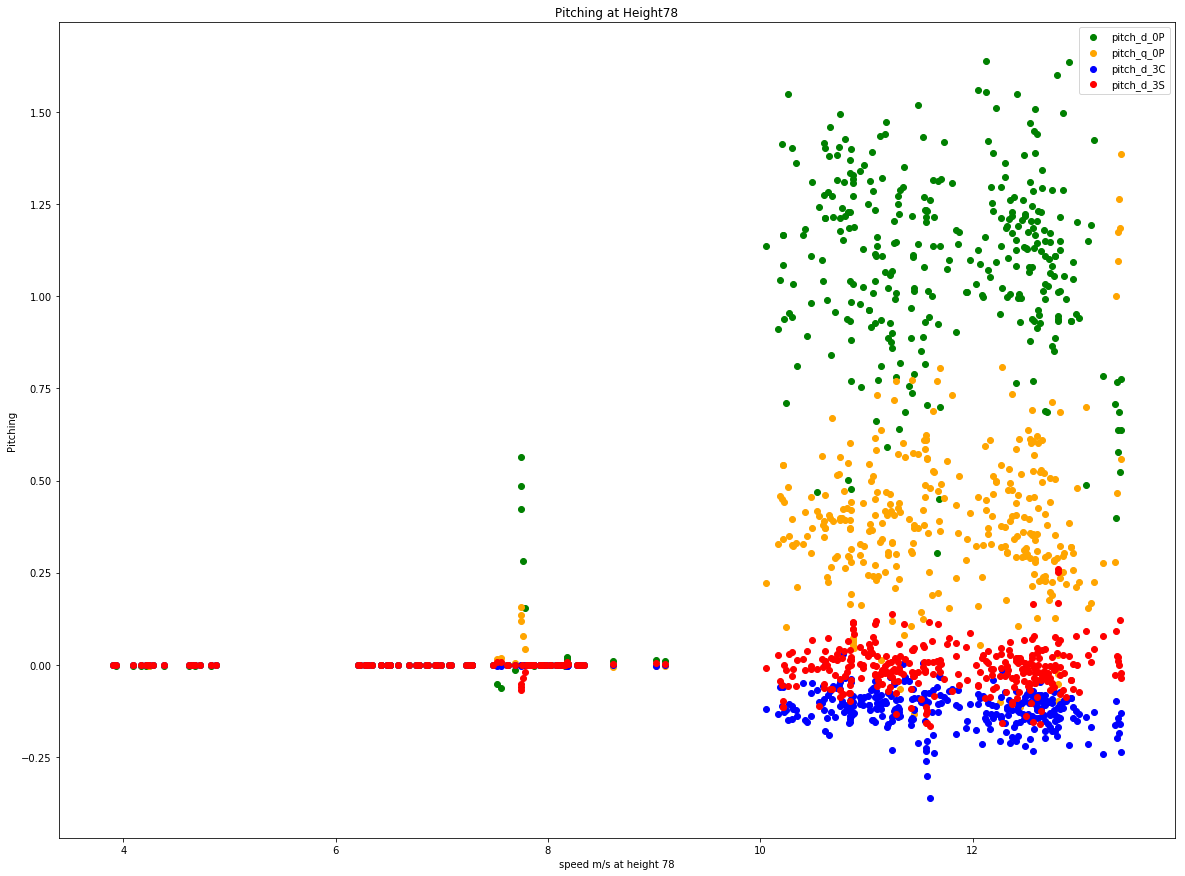

In [34]:
# At height 78 pitch angles on 17TH JUNE 2015
plt.figure(figsize=(20,15))
plt.scatter(dataset.m78[0:407], dataset.pitch_d_0P[0:407], color='g')
plt.scatter(dataset.m78[0:407], dataset.pitch_q_0P[0:407], color='orange')
plt.scatter(dataset.m78[0:407], dataset.pitch_d_3C[0:407], color='blue')
plt.scatter(dataset.m78[0:407], dataset.pitch_d_3S[0:407], color='red')
plt.xlabel('speed m/s at height 78')
plt.ylabel('Pitching')
plt.title('Pitching at Height78')
plt.legend()
plt.show()

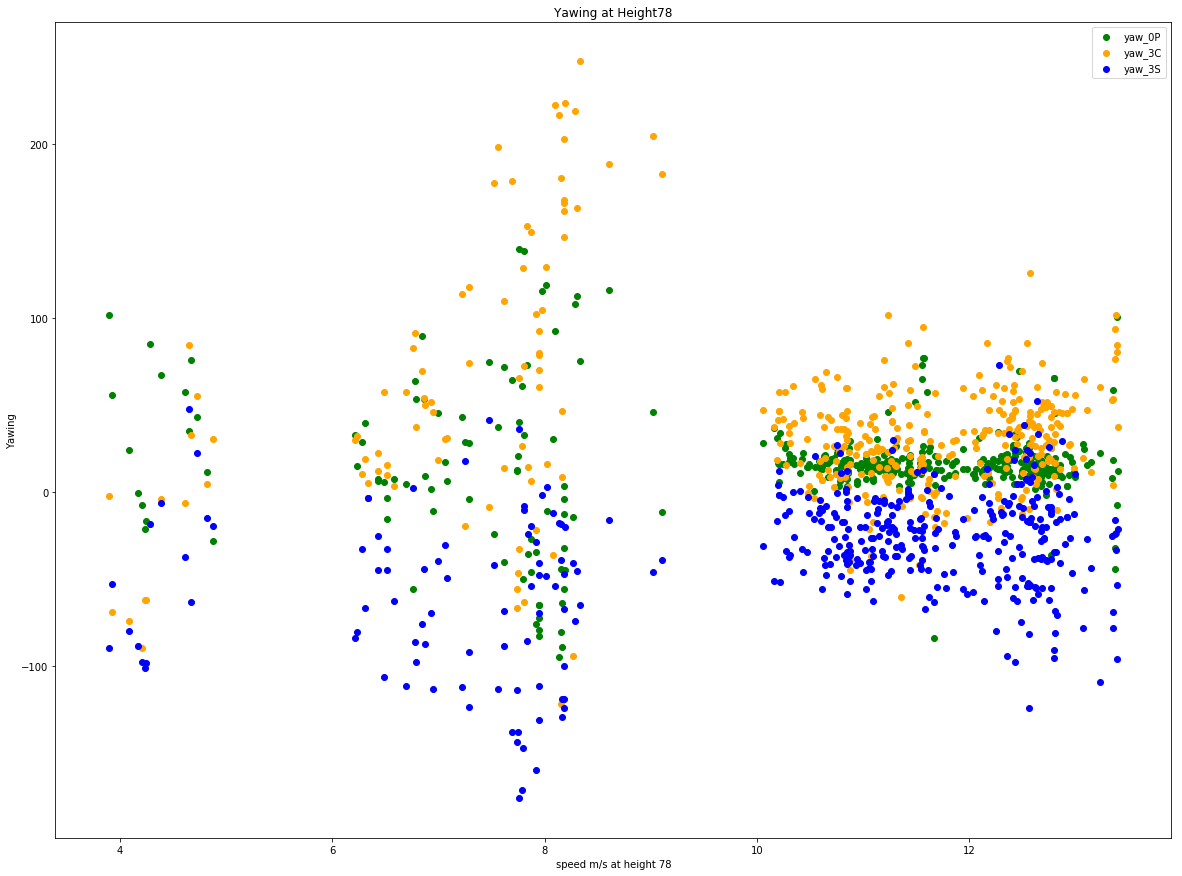

In [35]:
# At height 78 Yawing on 17TH JUNE 2015
plt.figure(figsize=(20,15))
plt.scatter(dataset.m78[0:407], dataset.yaw_0P[0:407], color='g')
plt.scatter(dataset.m78[0:407], dataset.yaw_3C[0:407], color='orange')
plt.scatter(dataset.m78[0:407], dataset.yaw_3S[0:407], color='blue')
plt.xlabel('speed m/s at height 78')
plt.ylabel('Yawing')
plt.title('Yawing at Height78')
plt.legend()
plt.show()

In [36]:
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [37]:
# Separate Variables 'X' and 'y' from the dataset
X = dataset.iloc[:, 6:20].values
y = dataset.iloc[:, 20].values
validation_size = 0.25
seed=7

In [38]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = validation_size, random_state = seed)

In [39]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
Sc_x = StandardScaler()
X_train = Sc_x.fit_transform(X_train)
X_test = Sc_x.transform(X_test)

In [40]:
# Applying PCA (Principal Component Analysis)

from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [41]:
X_train

array([[-1.97274925,  2.28001813],
       [-2.81931167, -2.02035435],
       [ 1.06940708,  0.44856727],
       ...,
       [ 1.19470028, -0.6630393 ],
       [ 0.76465396,  0.16530861],
       [ 3.39256105,  0.23235038]])

In [42]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [43]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.814710 (0.018224)
LDA: 0.810899 (0.020450)
KNN: 0.848686 (0.015951)
CART: 0.785377 (0.020305)
NB: 0.819020 (0.017400)
SVM: 0.853821 (0.016661)


In [44]:
cv_results

array([0.84768212, 0.89072848, 0.85761589, 0.86258278, 0.8358209 ,
       0.83416252, 0.85572139, 0.83250415, 0.86401327, 0.85737977])

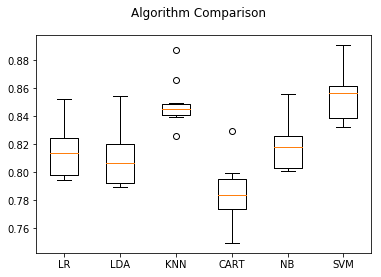

In [45]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [46]:
svm = SVC()
svm = SVC(C=50).fit(X_train, y_train)
predictions = svm.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8608349900596421
[[1558   32    0    0]
 [ 116  174    0    0]
 [ 100    2    0    0]
 [  28    2    0    0]]
             precision    recall  f1-score   support

          0       0.86      0.98      0.92      1590
          1       0.83      0.60      0.70       290
          2       0.00      0.00      0.00       102
          3       0.00      0.00      0.00        30

avg / total       0.80      0.86      0.83      2012



In [47]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,]}]

In [ ]:
grid_search = GridSearchCV(estimator = svm, param_grid =  parameters, scoring = 'accuracy', cv = 10, n_jobs= -1)

grid_search = grid_search.fit(X_train, y_train)

In [ ]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_